<a href="https://colab.research.google.com/github/Sjleerodls/Data_Analysis/blob/main/lab_da/ml19_cnn_exercise_%EC%9D%B4%EC%84%B1%EC%9E%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN  연습

*   Keras 패키지의 손글씨 MNIST 예제 데이터셋을 다운로드하세요.
*   예제 데이터셋의 일부(예: 100개)를 시각화해 보세요.
*   훈련 셋과 테스트 셋의 데이터는 0. ~ 1. 스케일로 스케일링하세요.
*   전체 훈련 셋은 다시 훈련 셋과 검증 셋으로 나누세요.
*   아래의 CNN 모델 구조처럼 합성곱 신경망을 설계하세요.
*   모든 합성곱 층의 커널 사이즈는 3으로 설정하세요.
*   모든 합성곱 층(Conv2D)와 출력층을 제외한 밀집층(Dense)에서
    *   활성화 함수는 ReLU로 설정하세요.
    *   커널 초기화 함수(kernel initialize)를 'he_normal'로 설정하세요.
*   첫번째 Dropout 층의 rate는 0.25로 설정하세요.
*   두번째 Dropout 층의 rate는 0.5로 설정하세요.
*   모델의 옵티마이저(optimizer)는 Nadam을 사용하세요.
*   ModelCheckpoint, EarlyStopping 콜백들과 검증 셋을 함께 사용해서 모델을 훈련하세요.
    *   최적의 모델은 cnn_ex_best.keras 파일로 저장하세요.
*   모델의 성능을 평가하세요.

---

__CNN example__

<img src="https://raw.githubusercontent.com/JakeOh/202505_BD50/refs/heads/main/lab_da/cnn_example_64dpi.png" alt="CNN example" />


# Imports

In [10]:
import keras

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [11]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# MNIST 데이터셋 다운로드

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(x_train_full.shape)
print(y_train_full.shape)

(60000, 28, 28)
(60000,)


In [5]:
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [12]:
np.unique(y_train_full, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

In [15]:
def plot_mnist_image(arr, ncols=10):
    # arr : (n_samples, height, width) 또는 (n_samples, height, width, n_channels)
    n_samples = len(arr)
    nrows = int(np.ceil(n_samples / ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))

    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            if nrows == 1 or ncols == 1:
                if idx < n_samples:
                    ax[idx].imshow(arr[idx], cmap=plt.cm.binary)
                ax[idx].axis('off')
            else:
                if idx < n_samples:
                    ax[i, j].imshow(arr[idx], cmap=plt.cm.binary)
                ax[i, j].axis('off')
    plt.show()

# 데이터셋 일부 시각화

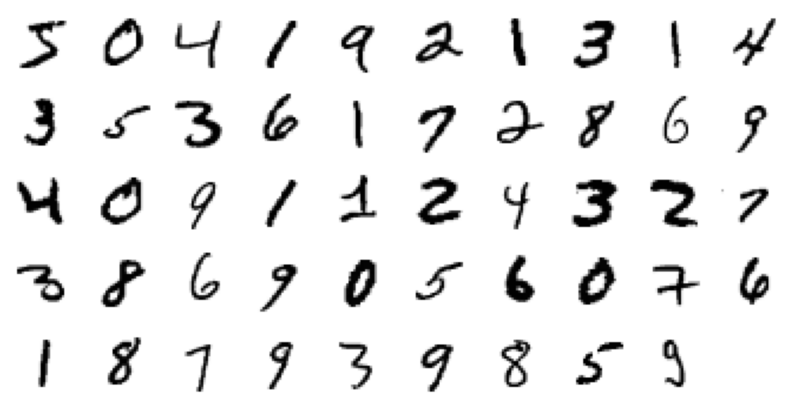

In [16]:
plot_mnist_image(x_train_full[:49])

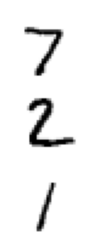

In [17]:
plot_mnist_image(x_test[:3], ncols=1)

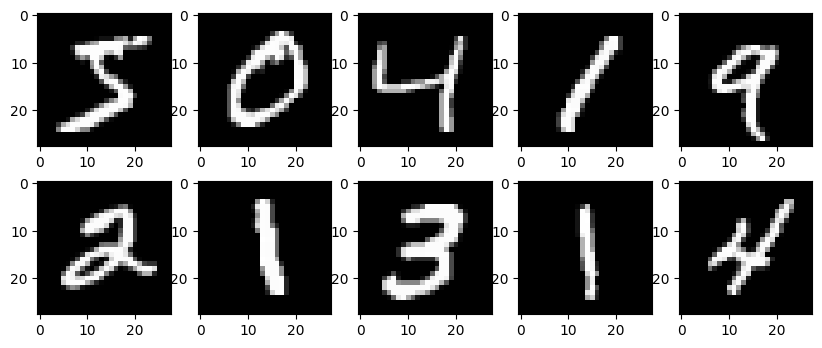

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
  for j in range(5):
    ax[i,j].imshow(x_train_full[i*5+j], cmap='gray')

plt.show()

# 데이터 셋 reshape & scaling

* 이미지 분류 합성곱 신경망에서는 이미지 배열의 모양이 (n_samples, height, width, n_channel)인 3차원 배열이라고 가정.
* 0. ~ 1. 실수 범위인 경우가 성능이 좋음.

In [22]:
np.max(x_train_full[0]), np.min(x_train_full[0])
#> 첫번째 이미지의 픽섹의 최댓값, 최솟값 -> 0 ~ 255 사이의 부호없는 8비트 정수.

(np.uint8(255), np.uint8(0))

# 훈련 셋과 테스트 셋의 데이터를 0. ~ 1. 스케일링

In [23]:
x_train_full_scaled = x_train_full.reshape((-1, 28, 28, 1)) / 255.0
x_test_scaled = x_test.reshape((-1, 28, 28, 1)) / 255.0

In [24]:
print(x_train_full.shape)
print(x_train_full_scaled.shape)

print(y_train_full.shape)

print(x_test.shape)
print(x_test_scaled.shape)

print(y_test.shape)

(60000, 28, 28)
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28)
(10000, 28, 28, 1)
(10000,)


In [25]:
np.max(x_train_full_scaled), np.min(x_train_full_scaled)

(np.float64(1.0), np.float64(0.0))

# 전체 훈련 셋 다시 훈련 셋과 검증 셋으로 나누기

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full_scaled, y_train_full, test_size=0.2, stratify=y_train_full)

In [27]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(48000, 28, 28, 1)
(48000,)
(12000, 28, 28, 1)
(12000,)


# 합성곱 신경망 설계

In [ ]:
# Sequential 객체 생성
model = keras.Sequential()

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
model.add(inputs)

In [ ]:
conv2d_init = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')
model.add(conv2d_init)

In [ ]:
conv2d_sec = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')
model.add(conv2d_sec)

In [ ]:
max_pooling2d = keras.layers.MaxPooling2D()
model.add(max_pooling2d)

In [ ]:
model.add(keras.layers.Flatten())

In [ ]:
model.add(keras.layers.Dropout(rate=0.25))

In [ ]:
dense_1 = keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')
model.add(dense_1)

In [ ]:
model.add(keras.layers.Dropout(rate=0.5))

In [ ]:
dense_2 = keras.layers.Dense(units=10, activation='softmax')
model.add(dense_2)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

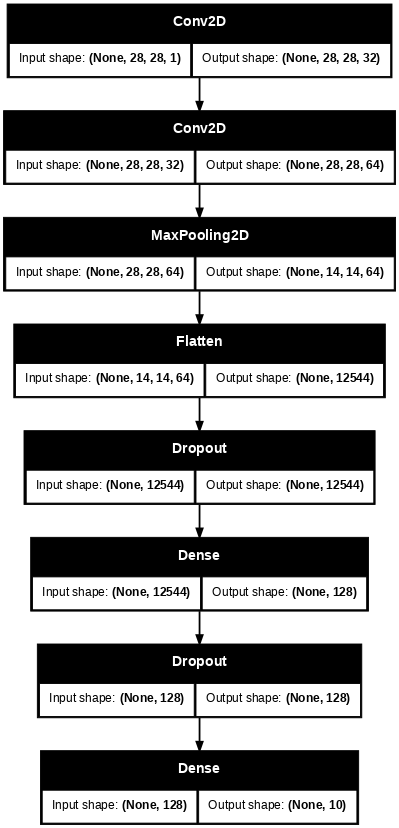

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

# 모델 컴파일
- 모델의 옵티마이저(optimizer)는 Nadam을 사용.

In [ ]:
model.compile(optimizer='nadam', loss=keras.losses.sparse_categorical_crossentropy, metrics=[keras.metrics.sparse_categorical_accuracy])

# 모델 훈련

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/lab_da/'
model_file = dir_path + 'cnn_ex_best.keras'

checkpoint = keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
result = model.fit(x=x_train, y=y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[checkpoint, early_stop])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 184s 121ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.0443 - val_sparse_categorical_accuracy: 0.9876
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 183s 122ms/step - loss: 0.0475 - sparse_categorical_accuracy: 0.9849 - val_loss: 0.0464 - val_sparse_categorical_accuracy: 0.9871
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 205s 124ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0447 - val_sparse_categorical_accuracy: 0.9884
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 212s 131ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0434 - val_sparse_categorical_accuracy: 0.9904
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 200s 129ms/step - loss: 0.0312 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0551 - val_sparse_categorical_accuracy: 0.9872
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 233s 150ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0487 - va

# 모델 성능 평가

In [ ]:
model.evaluate(x_train, y_train)   # 훈련 셋 손실/정확도

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - loss: 0.0057 - sparse_categorical_accuracy: 0.9984


[0.006043667905032635, 0.9980833530426025]

In [ ]:
model.evaluate(x_val, y_val)    # 검증 셋 손실/정확도

375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9893


[0.04339929297566414, 0.9904166460037231]

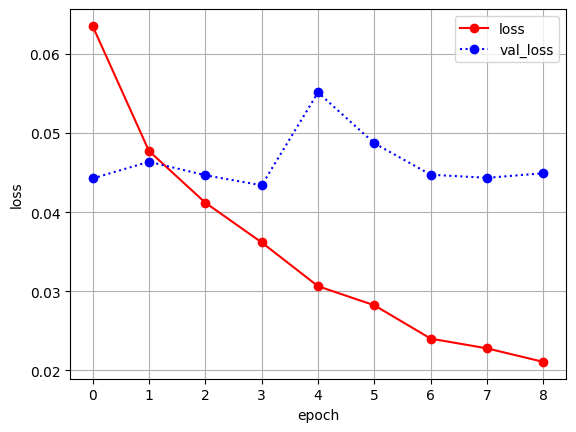

In [ ]:
plt.plot(result.epoch, result.history['loss'], 'ro-', label='loss')
plt.plot(result.epoch, result.history['val_loss'], 'bo:', label='val_loss')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch가 1 ~ 2 사이를 제외하면 나머지 부분은 과대적합이 매우 크게 일어남.